# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [1]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\MD DANISH
[nltk_data]     ANWER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)
print(ss)
for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')
type(ss)
# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

{'neg': 0.01, 'neu': 0.745, 'pos': 0.245, 'compound': 0.9975}
neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

dict

<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

#from chart_studio.plotly import plotly
#import chart_studio.plotly.offline as offline
#import chart_studio.plotlyplotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter

In [4]:
import pandas
data = pandas.read_csv('preprocessed_data.csv')

In [5]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [6]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
Y=data["project_is_approved"]
X=data.drop(columns=["project_is_approved"])
print("Number of datapoints of each class label")
data['project_is_approved'].value_counts()

Number of datapoints of each class label


1    92706
0    16542
Name: project_is_approved, dtype: int64

In [7]:
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(random_state=0)
X_resampled, y_resampled=ros.fit_resample(X,Y)
X=pd.DataFrame(X_resampled,columns=X.columns)
Y=y_resampled


In [8]:
from sklearn.model_selection import train_test_split
import math
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,random_state=52,stratify=Y)

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [9]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf(train,test):
    tfidfvec=TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
    tfidfvec.fit(train['essay'])
    train_tfidf=tfidfvec.transform(train['essay'])
    test_tfidf=tfidfvec.transform(test['essay'])
    return(tfidfvec,train_tfidf,test_tfidf)
def tfidfw2v(train,test):
    with open('glove_vectors', 'rb') as f:
        model = pickle.load(f)
        glove_words =  set(model.keys())
    tfidfvec=TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
    tfidfvec.fit(train['essay'])
    train_tfidf=tfidfvec.transform(train['essay'])
    test_tfidf=tfidfvec.transform(test['essay'])
    
    dictionary=dict(zip(tfidfvec.get_feature_names(),list(tfidfvec.idf_)))
    tfidf_words=set(tfidfvec.get_feature_names())
    tfidf_w2v_train=[]
    tfidf_w2v_test=[]
    for sentence in train['essay']:
        vector=np.zeros(300)
        tf_idf_weight=0
        for word in sentence.split():
            if (word in glove_words) and (word in tfidf_words):
                vec=model[word]
                tf_idf=dictionary[word]*(sentence.count(word)/len(sentence.split()))
                vector+=(vec*tf_idf)
                tf_idf_weight+=tf_idf
        if tf_idf_weight!=0:
            vector /= tf_idf_weight
        tfidf_w2v_train.append(vector)
    for sentence in test['essay']:
        vector=np.zeros(300)
        tf_idf_weight=0
        for word in sentence.split():
            if (word in glove_words) and (word in tfidf_words):
                vec=model[word]
                tf_idf=dictionary[word]*(sentence.count(word)/len(sentence.split()))
                vector+=(vec*tf_idf)
                tf_idf_weight+=tf_idf
        if tf_idf_weight!=0:
            vector /= tf_idf_weight
        tfidf_w2v_test.append(vector)
    return(tfidf_w2v_train,tfidf_w2v_test)
    




In [10]:
tfidf,train_tfidf,test_tfidf=tfidf(xtrain,xtest)

In [11]:
print(train_tfidf.shape)
print(test_tfidf.shape)

(139059, 5000)
(46353, 5000)


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_w2v_train,tfidf_w2v_test=tfidfw2v(xtrain,xtest)

In [13]:
print(len(tfidf_w2v_train))
print(len(tfidf_w2v_train[0]))


139059
300


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [14]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.feature_extraction.text import CountVectorizer
def responsecoding(col,data,ytrain):
    ztrain=ytrain.tolist()
    
    features_name=list(set(data[col].tolist()))
   
    
    dict={}
    for name in features_name:
        dict[name]={'1':0, '0':0}
    for i in range(len(data)):
        if ztrain[i]==1:
            dict[data.iloc[i][col]]['1']+=1
        else:
            dict[data.iloc[i][col]]['0']+=1
    for name in features_name:
        dict[name]['1']= dict[name]['1']/(dict[name]['1']+dict[name]['0'])
        dict[name]['0']=1-dict[name]['1']
    
    return(dict)


from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
def encodingnumericalfeatures(train,test):
    normalizer = Normalizer()
    normalizer.fit(train)
    return(normalizer.transform(train),normalizer.transform(test))


#print(x_train_prc_nor.m

In [15]:
## Sentiment Analyzer

def SentimentAnalyzer(col):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    neu=[]  
    pos=[]  
    compound=[]  
    for essay in col:
        ss = sid.polarity_scores(essay)
        neg.append(ss['neg'])
        neu.append(ss['neu'])
        pos.append(ss['pos'])
        compound.append(ss['compound'])
    return(neg,neu,pos,compound)
    


In [16]:
neg_train_essay,neu_train_essay,pos_train_essay,compound_train_essay=SentimentAnalyzer(xtrain['essay'])
neg_test_essay,neu_test_essay,pos_test_essay,compound_test_essay=SentimentAnalyzer(xtest['essay'])


In [17]:
x_train_tchpst_nor,x_test_tchpst_nor=encodingnumericalfeatures(xtrain['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),xtest['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_train_prc_nor,x_test_prc_nor=encodingnumericalfeatures(xtrain["price"].values.reshape(-1,1),xtest["price"].values.reshape(-1,1)) 

In [18]:
school_state_response_coding=responsecoding("school_state",xtrain,ytrain)
teacher_prefix_response_coding=responsecoding("teacher_prefix",xtrain,ytrain)
project_grade_category_response_coding=responsecoding("project_grade_category",xtrain,ytrain)
clean_categories_response_coding=responsecoding("clean_categories",xtrain,ytrain)
clean_subcategories_response_coding=responsecoding("clean_subcategories",xtrain,ytrain)

In [19]:
prob_school_state_train=[]
prob_teacher_prefix_train=[]
prob_project_grade_category_train=[]
prob_clean_categories_train=[]
prob_clean_subcategories_train=[]
for list in xtrain["school_state"]:
    prob_school_state_train.append([school_state_response_coding[list]['1'],school_state_response_coding[list]['0']])
for list in xtrain["teacher_prefix"]:
    prob_teacher_prefix_train.append([teacher_prefix_response_coding[list]['1'],teacher_prefix_response_coding[list]['0']])
for list in xtrain["project_grade_category"]:
    prob_project_grade_category_train.append([project_grade_category_response_coding[list]['1'],project_grade_category_response_coding[list]['0']])
for list in xtrain["clean_categories"]:
    prob_clean_categories_train.append([clean_categories_response_coding[list]['1'],clean_categories_response_coding[list]['0']])
for list in xtrain["clean_subcategories"]:
    prob_clean_subcategories_train.append([clean_subcategories_response_coding[list]['1'],clean_subcategories_response_coding[list]['0']])

prob_school_state_test=[]
prob_teacher_prefix_test=[]
prob_project_grade_category_test=[]
prob_clean_categories_test=[]
prob_clean_subcategories_test=[]
for list in xtest["school_state"]:
    try:
        prob_school_state_test.append([school_state_response_coding[list]['1'],school_state_response_coding[list]['0']])
    except:
        prob_school_state_test.append([0.5,0.5])
for list in xtest["teacher_prefix"]:
    try:
        prob_teacher_prefix_test.append([teacher_prefix_response_coding[list]['1'],teacher_prefix_response_coding[list]['0']])
    except:
        prob_teacher_prefix_test.append([0.5,0.5])
for list in xtest["project_grade_category"]:
    try:
        prob_project_grade_category_test.append([project_grade_category_response_coding[list]['1'],project_grade_category_response_coding[list]['0']])
    except:
        prob_project_grade_category_test.append([0.5,0.5])
for list in xtest["clean_categories"]:
    try:
        prob_clean_categories_test.append([clean_categories_response_coding[list]['1'],clean_categories_response_coding[list]['0']])
    except:
        prob_clean_categories_test.append([0.5,0.5])
for list in xtest["clean_subcategories"]:
    try:
        prob_clean_subcategories_test.append([clean_subcategories_response_coding[list]['1'],clean_subcategories_response_coding[list]['0']])
    except:
        prob_clean_subcategories_test.append([0.5,0.5])

In [20]:
Xtrain_tfidf=np.hstack((train_tfidf.toarray(),prob_school_state_train,prob_teacher_prefix_train,prob_project_grade_category_train,prob_clean_categories_train,prob_clean_subcategories_train,x_train_tchpst_nor,x_train_prc_nor))
Xtest_tfidf=np.hstack((test_tfidf.toarray(),prob_school_state_test,prob_teacher_prefix_test,prob_project_grade_category_test,prob_clean_categories_test,prob_clean_subcategories_test,x_test_tchpst_nor,x_test_prc_nor))

In [21]:
Xtrain_tfidfw2v=np.hstack((tfidf_w2v_train,prob_school_state_train,prob_teacher_prefix_train,prob_project_grade_category_train,prob_clean_categories_train,prob_clean_subcategories_train,x_train_tchpst_nor,x_train_prc_nor))
Xtest_tfidfw2v=np.hstack((tfidf_w2v_test,prob_school_state_test,prob_teacher_prefix_test,prob_project_grade_category_test,prob_clean_categories_test,prob_clean_subcategories_test,x_test_tchpst_nor,x_test_prc_nor))

<strong>Apply GBDT on these 1st feature sets(TFIDF)</strong>

In [24]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


In [28]:
xgb_model=xgb.XGBClassifier()
parameters = {'n_estimators':[1,5,10,50], 'max_depth' :[1, 5, 10,15,100]}
clf = GridSearchCV(xgb_model, parameters,scoring="roc_auc",return_train_score=True)
clf.fit(Xtrain_tfidf,ytrain)


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [43]:
pd.DataFrame(clf.cv_results_).head()
clf.cv_results_['mean_test_score'].tolist()

[0.5505236753497684,
 0.6164299281695872,
 0.6361628306315609,
 0.6795272003556413,
 0.6245939126756993,
 0.6777307471377263,
 0.7052561104593276,
 0.7788974362765487,
 0.6803818080105961,
 0.7642678191151919,
 0.8013420550929314,
 0.8952842178731194,
 0.7340150731837377,
 0.8484018538281214,
 0.8863054629087556,
 0.9559527823145535,
 0.867479794820316,
 0.9759572012912825,
 0.9851201604643769,
 0.9891368813269497]

In [72]:
testscore=clf.cv_results_['mean_test_score'].tolist()
trainscore=clf.cv_results_['mean_train_score'].tolist()
x1=clf.cv_results_['param_max_depth'].tolist()
y1=clf.cv_results_['param_n_estimators'].tolist()


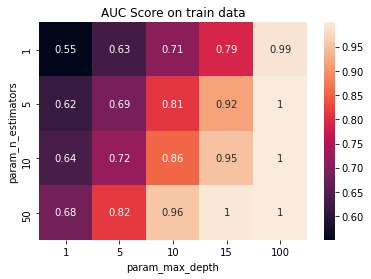

In [73]:
df=pd.DataFrame((zip(y1,x1,trainscore)),columns =[ 'param_n_estimators','param_max_depth','trainscore'])
df=df.pivot('param_n_estimators',"param_max_depth",'trainscore')
ax = sns.heatmap(df, annot=True).set_title('AUC Score on train data')


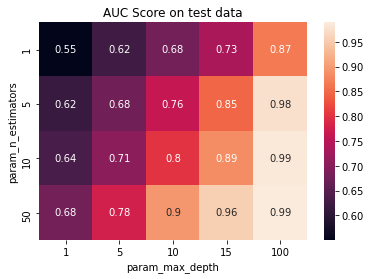

In [74]:
df=pd.DataFrame((zip(y1,x1,testscore)),columns =[ 'param_n_estimators','param_max_depth','testscore'])
df=df.pivot('param_n_estimators',"param_max_depth",'testscore')
ax = sns.heatmap(df, annot=True).set_title('AUC Score on test data')


In [75]:
%matplotlib inline
import plotly.graph_objects as go
trace1 = go.Scatter3d(x=x1,y=y1,z=trainscore, name = 'train')
trace2 = go.Scatter3d(x=x1,y=y1,z=testscore, name = 'Cross validation')
data = [trace1, trace2]
layout = go.Layout(scene = dict(
 xaxis = dict(title='n_estimators'),
 yaxis = dict(title='max_depth'),
 zaxis = dict(title='AUC'),))
fig = go.Figure(data=data, layout=layout)
fig.show()


In [66]:
print(clf.best_params_)


{'max_depth': 100, 'n_estimators': 50}


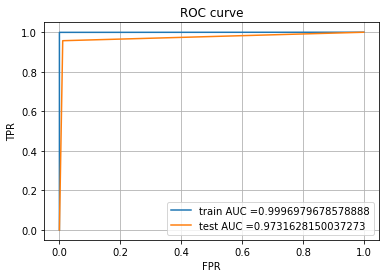

In [69]:
from sklearn.metrics import roc_auc_score
xgb_model=xgb.XGBClassifier(max_depth=100, n_estimators=50,random_state=0)
xgb_model.fit(Xtrain_tfidf,ytrain)
y_test_pred=xgb_model.predict(Xtest_tfidf)
y_train_pred=xgb_model.predict(Xtrain_tfidf)
train_fpr, train_tpr, tr_thresholds = roc_curve(ytrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(ytest, y_test_pred) 
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(ytrain,y_train_pred))
print("Test confusion matrix")
print(confusion_matrix(ytest,y_test_pred))

<strong>Apply GBDT on these 2nd feature sets(TFIDF+W2V)</strong>

In [30]:
xgb_model=xgb.XGBClassifier()
parameters = {'n_estimators':[1,5,10,50], 'max_depth' :[1, 5, 10,15,100]}
clf_w2v = GridSearchCV(xgb_model, parameters,scoring="roc_auc",return_train_score=True)
clf_w2v.fit(Xtrain_tfidfw2v,ytrain)


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [32]:
pd.DataFrame(clf_w2v.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.473104,0.518701,0.162312,0.005963,1,1,"{'max_depth': 1, 'n_estimators': 1}",0.552244,0.556630,0.557961,...,0.554461,0.002518,20,0.558703,0.555519,0.554926,0.556580,0.556145,0.556375,0.001292
1,1.500139,0.008752,0.160236,0.000749,1,5,"{'max_depth': 1, 'n_estimators': 5}",0.614669,0.622035,0.621790,...,0.617497,0.003646,19,0.618876,0.617221,0.618184,0.618801,0.619720,0.618560,0.000829
2,1.869822,0.006345,0.165037,0.001265,1,10,"{'max_depth': 1, 'n_estimators': 10}",0.628580,0.636369,0.636945,...,0.632660,0.003483,17,0.632146,0.633305,0.634341,0.635525,0.637341,0.634532,0.001795
3,5.046397,0.031310,0.165637,0.001020,1,50,"{'max_depth': 1, 'n_estimators': 50}",0.670820,0.677122,0.671820,...,0.671166,0.003517,16,0.675021,0.675741,0.674803,0.675886,0.676623,0.675615,0.000651
4,1.487415,0.012394,0.161537,0.001000,5,1,"{'max_depth': 5, 'n_estimators': 1}",0.624642,0.632908,0.638136,...,0.629670,0.005097,18,0.639359,0.638114,0.637937,0.639901,0.639688,0.639000,0.000816


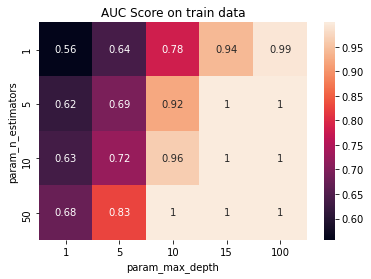

In [61]:
testscore=clf_w2v.cv_results_['mean_test_score'].tolist()
trainscore=clf_w2v.cv_results_['mean_train_score'].tolist()
x1=clf_w2v.cv_results_['param_max_depth'].tolist()
y1=clf_w2v.cv_results_['param_n_estimators'].tolist()
df=pd.DataFrame((zip(y1,x1,trainscore)),columns =[ 'param_n_estimators','param_max_depth','trainscore'])
df=df.pivot('param_n_estimators',"param_max_depth",'trainscore')
ax = sns.heatmap(df, annot=True).set_title('AUC Score on train data')


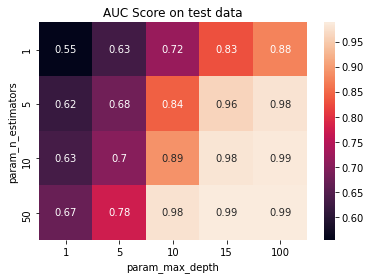

In [62]:
df=pd.DataFrame((zip(y1,x1,testscore)),columns =[ 'param_n_estimators','param_max_depth','testscore'])
df=df.pivot('param_n_estimators',"param_max_depth",'testscore')
ax = sns.heatmap(df, annot=True).set_title('AUC Score on test data')

In [64]:
%matplotlib inline
import plotly.graph_objects as go
trace1 = go.Scatter3d(x=x1,y=y1,z=trainscore, name = 'train')
trace2 = go.Scatter3d(x=x1,y=y1,z=testscore, name = 'Cross validation')
data = [trace1, trace2]
layout = go.Layout(scene = dict(
 xaxis = dict(title='n_estimators'),
 yaxis = dict(title='max_depth'),
 zaxis = dict(title='AUC'),))
fig = go.Figure(data=data, layout=layout)
fig.show()


In [70]:
print(clf_w2v.best_params_)

{'max_depth': 100, 'n_estimators': 50}


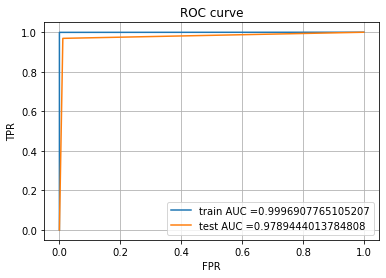

In [76]:
from sklearn.metrics import roc_auc_score
xgb_model=xgb.XGBClassifier(max_depth=100, n_estimators=50,random_state=0)
xgb_model.fit(Xtrain_tfidfw2v,ytrain)
y_test_pred=xgb_model.predict(Xtest_tfidfw2v)
y_train_pred=xgb_model.predict(Xtrain_tfidfw2v)
train_fpr, train_tpr, tr_thresholds = roc_curve(ytrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(ytest, y_test_pred) 
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(ytrain,y_train_pred))
print("Test confusion matrix")
print(confusion_matrix(ytest,y_test_pred))


len(ytrain)

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [12]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.feature_extraction.text import TfidfVectorizer

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [ ]:
from tabulate import tabulate
table = [["tfidf","DT",auctfidf],["tfidfw2v","DT", auctfidfw2v],["tfidf
+Feature Extraction","DT",auctfidffea],["tfidf+Feature Extractio+SENTIM
ENT ANALYZER","DT",auctfidNLTK]]
headers = ["VECTORIZER", "MODEL","AUC SCORE"]
print(tabulate(table, headers, tablefmt="grid"))

In [ ]:
from tabulate import tabulate
table = [["tfidf","DT",auctfidf],["tfidfw2v","DT", auctfidfw2v],["tfidf
+Feature Extraction","DT",auctfidffea],["tfidf+Feature Extractio+SENTIM
ENT ANALYZER","DT",auctfidNLTK]]
headers = ["VECTORIZER", "MODEL","AUC SCORE"]
print(tabulate(table, headers, tablefmt="grid"))